# NUTS_In/Out_flow_map

To generate the time series map .gif

Source: Meta  
Publisher: HDX (https://data.humdata.org/dataset/international-migration-flows)   
New York Times Article: https://www.nytimes.com/interactive/2025/04/17/opinion/global-migration-facebook-data.html   
Special countries: BA, UA, XK, UK/GB, EL/GR 

In [1]:
import os
import gc
import rasterio
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm import tqdm
import geopandas as gpd
from pathlib import Path
from osgeo import gdal, osr
import imageio.v2 as imageio
import dask_geopandas as dgpd
import matplotlib.pyplot as plt
from rasterstats import zonal_stats
from matplotlib.colors import LinearSegmentedColormap

BASE_DIR = Path('/Users/wenlanzhang/PycharmProjects/Mapineq/src/data-wrangling/')
DATA_DIR = Path('/Users/wenlanzhang/Downloads/PhD_UCL/Data/Oxford')
output_dir = Path("gif_frames")


# Load NTUS

In [2]:
# Load a GeoJSON file
gdf_2024 = gpd.read_file(DATA_DIR/"NUTS/NUTS_RG_01M_2024_3035.geojson")

gdf_country_2024 = gdf_2024[gdf_2024['LEVL_CODE'] == 0]
gdf_country_2024 = gdf_country_2024[['CNTR_CODE', 'geometry']].reset_index(drop=True)
gdf_country_2024

,CNTR_CODE,geometry
0,EL,"MULTIPOLYGON (((6083881.558 1676236.011, 60838..."
1,ES,"MULTIPOLYGON (((3815056.85 1904971.998, 381575..."
2,FI,"MULTIPOLYGON (((4999905.463 5305310.537, 50031..."
3,FR,"MULTIPOLYGON (((9980485.23 -3029930.054, 99812..."
4,HR,"MULTIPOLYGON (((4809521.18 2624665.768, 480963..."
5,EE,"MULTIPOLYGON (((5200614.71 4159725.901, 520083..."
6,DE,"MULTIPOLYGON (((4355225.354 2715902.995, 43548..."
7,DK,"MULTIPOLYGON (((4650283.775 3591676.53, 465057..."
8,BA,"MULTIPOLYGON (((4866544.51 2485914.128, 486624..."
9,AT,"MULTIPOLYGON (((4354847.685 2714710.627, 43552..."


In [3]:
# Load a GeoJSON file
gdf_2021 = gpd.read_file(DATA_DIR/"NUTS/NUTS_RG_01M_2021_3035.geojson")

gdf_country_2021 = gdf_2021[gdf_2021['LEVL_CODE'] == 0]
gdf_country_2021 = gdf_country_2021[['CNTR_CODE', 'geometry']].reset_index(drop=True)
uk_2021 = gdf_country_2021[gdf_country_2021['CNTR_CODE'] == 'UK']
uk_2021

,CNTR_CODE,geometry
34,UK,"MULTIPOLYGON (((3546135.14 4022028.934, 354660..."


In [4]:
# Concatenate with 2024 data
gdf_country = pd.concat(
    [gdf_country_2024, uk_2021],
    ignore_index=True  # Reset index
)
gdf_country

,CNTR_CODE,geometry
0,EL,"MULTIPOLYGON (((6083881.558 1676236.011, 60838..."
1,ES,"MULTIPOLYGON (((3815056.85 1904971.998, 381575..."
2,FI,"MULTIPOLYGON (((4999905.463 5305310.537, 50031..."
3,FR,"MULTIPOLYGON (((9980485.23 -3029930.054, 99812..."
4,HR,"MULTIPOLYGON (((4809521.18 2624665.768, 480963..."
5,EE,"MULTIPOLYGON (((5200614.71 4159725.901, 520083..."
6,DE,"MULTIPOLYGON (((4355225.354 2715902.995, 43548..."
7,DK,"MULTIPOLYGON (((4650283.775 3591676.53, 465057..."
8,BA,"MULTIPOLYGON (((4866544.51 2485914.128, 486624..."
9,AT,"MULTIPOLYGON (((4354847.685 2714710.627, 43552..."


In [5]:
country_list = gdf_country['CNTR_CODE'].unique()
len(country_list)
country_list

array(['EL', 'ES', 'FI', 'FR', 'HR', 'EE', 'DE', 'DK', 'BA', 'AT', 'BG',
       'CH', 'CY', 'BE', 'CZ', 'AL', 'LU', 'LV', 'ME', 'IE', 'IS', 'IT',
       'MK', 'MT', 'LI', 'NL', 'LT', 'HU', 'RS', 'SE', 'SI', 'TR', 'UA',
       'SK', 'RO', 'NO', 'PL', 'PT', 'XK', 'UK'], dtype=object)

# Load Migration

In [6]:
df = pd.read_csv(DATA_DIR/f"Migration/international_migration_flow.csv") 
df['year'] = pd.to_datetime(df['migration_month']).dt.year
df['month'] = pd.to_datetime(df['migration_month']).dt.month

# Define the mapping of old codes to new codes
country_code_mapping = {
    'GR': 'EL',  # Greece (GR → EL)
    'GB': 'UK'   # United Kingdom (GB → UK)
}

# Apply the replacement to both columns
df['country_from'] = df['country_from'].replace(country_code_mapping)
df['country_to'] = df['country_to'].replace(country_code_mapping)

df
# len(df['country_from'].unique())

,country_from,country_to,migration_month,num_migrants,year,month
0,AD,AE,2019-01,12,2019,1
1,AD,AE,2019-02,2,2019,2
2,AD,AE,2019-03,1,2019,3
3,AD,AE,2019-04,7,2019,4
4,AD,AE,2019-05,0,2019,5
...,...,...,...,...,...,...
1563149,ZW,ZM,2022-08,138,2022,8
1563150,ZW,ZM,2022-09,162,2022,9
1563151,ZW,ZM,2022-10,149,2022,10
1563152,ZW,ZM,2022-11,104,2022,11


In [7]:
# len(df['country_from'].unique())
len(df['country_to'].unique())
# df['country_to'].unique()

181

In [8]:
df[df['country_to'].isna()].groupby('country_from').size().unique()
# df[df['country_from'].isna()].groupby('country_to').size().unique()

array([48])

# Country Aggregation

In [9]:
def prepare_flow_data(df_input, flow_type: str, country_scope: str, country_list: list):
    # Determine the column based on flow direction
    flow_col = 'country_to' if flow_type == 'inflow' else 'country_from'

    # Optional: filter for EU countries
    if country_scope == 'eu_countries':
        df_input = df_input[df_input[flow_col].isin(country_list)]

    # Ensure 'month' column exists
    if 'month' not in df_input.columns:
        df_input['month'] = pd.to_datetime(df_input['migration_month']).dt.month

    # Yearly aggregation
    yearly = (
        df_input.groupby([flow_col, 'year'])
        .agg(migration_count_total=('num_migrants', 'sum'))
        .reset_index()
        .assign(month='all')  # Placeholder month
        .rename(columns={flow_col: 'geo', 'year': 'obsTime'})
    )

    # Monthly aggregation
    monthly = (
        df_input.groupby([flow_col, 'year', 'month'])
        .agg(migration_count_total=('num_migrants', 'sum'))
        .reset_index()
        .rename(columns={flow_col: 'geo', 'year': 'obsTime'})
    )

    # Combine both
    combined = pd.concat([yearly, monthly], ignore_index=True)

    # Melt to long format
    melted = combined.melt(
        id_vars=['geo', 'obsTime', 'month'],
        value_vars=['migration_count_total'],
        var_name='time_granularity',
        value_name='obsValue'
    )

    # Clean and tag
    melted['time_granularity'] = melted['time_granularity'].map({
        'migration_count_total': 'Total Migration'
    })
    melted['flow_type'] = flow_type
    melted['country'] = country_scope

    return melted

In [10]:
# Inflow
inflow_all = prepare_flow_data(df, 'inflow', 'all_countries', country_list)

# Outflow
outflow_all = prepare_flow_data(df, 'outflow', 'all_countries', country_list)

# Combine inflow and outflow into one final dataset
migration_combined = pd.concat([inflow_all, outflow_all], ignore_index=True)
migration_combined

,geo,obsTime,month,time_granularity,obsValue,flow_type,country
0,AD,2019,all,Total Migration,8390,inflow,all_countries
1,AD,2020,all,Total Migration,7908,inflow,all_countries
2,AD,2021,all,Total Migration,6923,inflow,all_countries
3,AD,2022,all,Total Migration,9685,inflow,all_countries
4,AE,2019,all,Total Migration,1248145,inflow,all_countries
...,...,...,...,...,...,...,...
18715,ZW,2022,8,Total Migration,4339,outflow,all_countries
18716,ZW,2022,9,Total Migration,4867,outflow,all_countries
18717,ZW,2022,10,Total Migration,6280,outflow,all_countries
18718,ZW,2022,11,Total Migration,5907,outflow,all_countries


In [11]:
migration_combined['geo'].unique()

array(['AD', 'AE', 'AF', 'AL', 'AM', 'AO', 'AR', 'AT', 'AU', 'AZ', 'BA',
       'BB', 'BD', 'BE', 'BF', 'BG', 'BH', 'BI', 'BJ', 'BN', 'BO', 'BR',
       'BS', 'BT', 'BW', 'BY', 'BZ', 'CA', 'CD', 'CF', 'CG', 'CH', 'CI',
       'CL', 'CM', 'CO', 'CR', 'CV', 'CY', 'CZ', 'DE', 'DJ', 'DK', 'DO',
       'DZ', 'EC', 'EE', 'EG', 'EL', 'ER', 'ES', 'ET', 'FI', 'FJ', 'FM',
       'FR', 'GA', 'GD', 'GE', 'GH', 'GM', 'GN', 'GQ', 'GT', 'GW', 'GY',
       'HK', 'HN', 'HR', 'HT', 'HU', 'ID', 'IE', 'IL', 'IN', 'IQ', 'IS',
       'IT', 'JM', 'JO', 'JP', 'KE', 'KG', 'KH', 'KI', 'KM', 'KR', 'KW',
       'KZ', 'LA', 'LB', 'LC', 'LK', 'LR', 'LS', 'LT', 'LU', 'LV', 'LY',
       'MA', 'MD', 'ME', 'MG', 'MK', 'ML', 'MM', 'MN', 'MO', 'MR', 'MT',
       'MU', 'MV', 'MW', 'MX', 'MY', 'MZ', 'NE', 'NG', 'NI', 'NL', 'NO',
       'NP', 'NZ', 'OM', 'PA', 'PE', 'PG', 'PH', 'PK', 'PL', 'PT', 'PY',
       'QA', 'RO', 'RS', 'RU', 'RW', 'SA', 'SB', 'SD', 'SE', 'SG', 'SI',
       'SK', 'SL', 'SN', 'SR', 'SS', 'ST', 'SV', 'S

# Individual Country

## UA (per month)

In [12]:
# # --- Parameters ---
# flow_ty = "inflow"  # Change to "inflow" if needed
# output_dir = Path("gif_frames")
# gif_filename = f"ua_{flow_ty}_migration_flows.gif"
# output_dir.mkdir(exist_ok=True)

# # --- Ensure datetime format ---
# df['migration_month'] = pd.to_datetime(df['migration_month'])

# # --- Filter based on flow direction ---
# if flow_ty == "outflow":
#     df_flow = df[df['country_from'] == 'UA'].copy()
#     merge_key = 'country_to'
#     plot_label = 'Migrants from UA'
#     title_prefix = 'Outflows from Ukraine'
# elif flow_ty == "inflow":
#     df_flow = df[df['country_to'] == 'UA'].copy()
#     merge_key = 'country_from'
#     plot_label = 'Migrants to UA'
#     title_prefix = 'Inflows to Ukraine'
# else:
#     raise ValueError("flow_ty must be 'inflow' or 'outflow'")

# # --- Rename for compatibility with gdf_country ---
# gdf_country = gdf_country.rename(columns={'CNTR_CODE': 'country_code'})

# # --- Set consistent color scale ---
# vmin = df_flow['num_migrants'].quantile(0.02)
# vmax = df_flow['num_migrants'].quantile(0.98)

# cmap = 'Blues' if flow_ty == 'inflow' else 'Purples'

# # --- Plotting function ---
# def plot_ua_flows(date, df_month, gdf_country, save_path):
#     merged = gdf_country.merge(df_month, left_on='country_code', right_on=merge_key, how='left')
#     merged['num_migrants'] = merged['num_migrants'].fillna(0)

#     fig, ax = plt.subplots(figsize=(12, 8))
#     merged.plot(
#         ax=ax,
#         column='num_migrants',
#         cmap=cmap,
#         vmin=vmin,
#         vmax=vmax,
#         legend=True,
#         legend_kwds={'label': plot_label}
#     )

#     # Always highlight Ukraine
#     gdf_country[gdf_country['country_code'] == 'UA'].plot(
#         ax=ax,
#         color='orange',
#         edgecolor='black',
#         linewidth=0.8
#     )
#     ax.set_xlim([2500000, 7500000])
#     ax.set_ylim([1300000, 5500000])
#     ax.set_title(f"{title_prefix} – {date.strftime('%Y-%m')}", fontsize=16)
#     ax.axis('off')
#     plt.savefig(save_path, bbox_inches='tight')
#     plt.close()

# # --- Loop over months ---
# for i, date in enumerate(tqdm(sorted(df_flow['migration_month'].unique()), desc="Generating frames")):
#     df_month = df_flow[df_flow['migration_month'] == date]
#     save_path = output_dir / f"ua_{flow_ty}_{i:02d}.png"
#     plot_ua_flows(date, df_month, gdf_country, save_path)

# # --- Create GIF ---
# images = []
# for i in range(len(df_flow['migration_month'].unique())):
#     frame_path = output_dir / f"ua_{flow_ty}_{i:02d}.png"
#     images.append(imageio.imread(frame_path))

# imageio.mimsave(gif_filename, images, fps=5, loop=0)
# print(f"GIF saved to {gif_filename}")

In [13]:
colors_in = ["#f7fcf0", "#e0f3db", "#ccebc5", "#a8ddb5", "#7bccc4", "#4eb3d3", "#2b8cbe", "#0868ac", "#084081"]  # light to dark blue
custom_cmap_in = LinearSegmentedColormap.from_list("my_cmap", colors_in)

colors_out = ["#f7fcfd", "#e0ecf4", "#bfd3e6", "#9ebcda", "#8c96c6", "#8c6bb1", "#88419d", "#810f7c", "#4d004b"]  # light to dark blue
custom_cmap_out = LinearSegmentedColormap.from_list("my_cmap", colors_out)

In [15]:
# --- Parameters ---
flow_ty = "inflow"  # Choose either "inflow" or "outflow"
start_date = "2021-10-01"  # <-- Set your desired start date
end_date = "2022-12-01"    # <-- Set your desired end date
output_dir = Path("gif_frames")
gif_filename = f"ua_{flow_ty}_migration_flows.gif"
output_dir.mkdir(exist_ok=True)

# --- Ensure datetime format ---
df['migration_month'] = pd.to_datetime(df['migration_month'])

# --- Filter based on flow direction ---
if flow_ty == "outflow":
    df_flow = df[df['country_from'] == 'UA'].copy()
    merge_key = 'country_to'
    plot_label = 'Migrants from UA'
    title_prefix = 'Outflows from Ukraine'
elif flow_ty == "inflow":
    df_flow = df[df['country_to'] == 'UA'].copy()
    merge_key = 'country_from'
    plot_label = 'Migrants to UA'
    title_prefix = 'Inflows to Ukraine'
else:
    raise ValueError("flow_ty must be 'inflow' or 'outflow'")

# --- Filter by date range ---
start_date = pd.to_datetime(start_date)
end_date = pd.to_datetime(end_date)
df_flow = df_flow[(df_flow['migration_month'] >= start_date) & (df_flow['migration_month'] <= end_date)]

# --- Rename for compatibility with gdf_country ---
gdf_country = gdf_country.rename(columns={'CNTR_CODE': 'country_code'})

# --- Set consistent color scale ---
vmin = df_flow['num_migrants'].quantile(0.02)
vmax = df_flow['num_migrants'].quantile(0.98)
# cmap = 'Blues' if flow_ty == 'inflow' else 'Purples'
cmap = custom_cmap_in if flow_ty == 'inflow' else custom_cmap_out

# --- Plotting function ---
def plot_ua_flows(date, df_month, gdf_country, save_path):
    merged = gdf_country.merge(df_month, left_on='country_code', right_on=merge_key, how='left')
    merged['num_migrants'] = merged['num_migrants'].fillna(0)

    fig, ax = plt.subplots(figsize=(12, 8))
    merged.plot(
        ax=ax,
        column='num_migrants',
        cmap=cmap,
        vmin=vmin,
        vmax=vmax,
        legend=True,
        legend_kwds={'label': plot_label}
    )

    # Always highlight Ukraine
    gdf_country[gdf_country['country_code'] == 'UA'].plot(
        ax=ax,
        color='#ffcf20FF',
        # edgecolor='grey',
        # linewidth=0.3
    )
    ax.set_xlim([2500000, 7500000])
    ax.set_ylim([1300000, 5500000])
    ax.set_title(f"{title_prefix} – {date.strftime('%Y-%m')}", fontsize=16)
    ax.axis('off')
    # plt.savefig(save_path, transparent=True)
    plt.savefig(save_path, bbox_inches='tight')
    plt.close()

# --- Loop over selected months ---
dates = sorted(df_flow['migration_month'].unique())
for i, date in enumerate(tqdm(dates, desc="Generating frames")):
    df_month = df_flow[df_flow['migration_month'] == date]
    save_path = output_dir / f"ua_{flow_ty}_{i:02d}.png"
    plot_ua_flows(date, df_month, gdf_country, save_path)

# --- Create GIF ---
images = []
for i in range(len(dates)):
    frame_path = output_dir / f"ua_{flow_ty}_{i:02d}.png"
    images.append(imageio.imread(frame_path))

imageio.mimsave(gif_filename, images, fps=5, loop=0)
print(f"GIF saved to {gif_filename}")

Generating frames: 100%|████████████████████████| 15/15 [00:17<00:00,  1.14s/it]


GIF saved to ua_inflow_migration_flows.gif


## UA (per year)

In [17]:
# --- Parameters ---
flow_ty = "inflow"  # Change to "outflow" or "inflow"
output_dir = Path("gif_frames_yearly")
gif_filename = f"ua_{flow_ty}_migration_flows_yearly.gif"
output_dir.mkdir(exist_ok=True)

# --- Ensure datetime format ---
df['migration_month'] = pd.to_datetime(df['migration_month'])
df['migration_year'] = df['migration_month'].dt.year

# --- Filter based on flow direction ---
if flow_ty == "outflow":
    df_flow = df[df['country_from'] == 'UA'].copy()
    merge_key = 'country_to'
    plot_label = 'Migrants from UA'
    title_prefix = 'Yearly Outflows from Ukraine'
elif flow_ty == "inflow":
    df_flow = df[df['country_to'] == 'UA'].copy()
    merge_key = 'country_from'
    plot_label = 'Migrants to UA'
    title_prefix = 'Yearly Inflows to Ukraine'
else:
    raise ValueError("flow_ty must be 'inflow' or 'outflow'")

# --- Aggregate yearly flows ---
df_yearly = (
    df_flow
    .groupby([merge_key, 'migration_year'], as_index=False)
    .agg({'num_migrants': 'sum'})
)

# --- Rename for compatibility with gdf_country ---
gdf_country = gdf_country.rename(columns={'CNTR_CODE': 'country_code'})

# --- Set consistent color scale ---
vmin = df_yearly['num_migrants'].quantile(0.03)
vmax = df_yearly['num_migrants'].quantile(0.97)
# cmap = 'Blues' if flow_ty == 'inflow' else 'Purples'
cmap = custom_cmap_in if flow_ty == 'inflow' else custom_cmap_out

# --- Plotting function ---
def plot_ua_flows(year, df_year, gdf_country, save_path):
    merged = gdf_country.merge(df_year, left_on='country_code', right_on=merge_key, how='left')
    merged['num_migrants'] = merged['num_migrants'].fillna(0)

    fig, ax = plt.subplots(figsize=(12, 8))
    merged.plot(
        ax=ax,
        column='num_migrants',
        cmap=cmap,
        vmin=vmin,
        vmax=vmax,
        legend=True,
        legend_kwds={'label': plot_label}
    )

    # Always highlight Ukraine
    gdf_country[gdf_country['country_code'] == 'UA'].plot(
        ax=ax,
        color='#ffcf20FF',
        edgecolor='grey',
        linewidth=0.3
    )
    ax.set_xlim([2500000, 7500000])
    ax.set_ylim([1300000, 5500000])
    ax.set_title(f"{title_prefix} – {year}", fontsize=16)
    ax.axis('off')
    plt.savefig(save_path, bbox_inches='tight')
    plt.close()

# --- Loop over years ---
years = sorted(df_yearly['migration_year'].unique())
for i, year in enumerate(tqdm(years, desc="Generating yearly frames")):
    df_year = df_yearly[df_yearly['migration_year'] == year]
    save_path = output_dir / f"ua_{flow_ty}_year_{i:02d}.png"
    plot_ua_flows(year, df_year, gdf_country, save_path)

# --- Create GIF ---
images = []
for i in range(len(years)):
    frame_path = output_dir / f"ua_{flow_ty}_year_{i:02d}.png"
    images.append(imageio.imread(frame_path))

imageio.mimsave(gif_filename, images, fps=5, loop=0)  # 1 fps for slower yearly animation
print(f"Yearly GIF saved to {gif_filename}")

Generating yearly frames: 100%|███████████████████| 4/4 [00:04<00:00,  1.17s/it]

Yearly GIF saved to ua_inflow_migration_flows_yearly.gif


## Stats

In [18]:
# Convert to datetime
df['migration_month'] = pd.to_datetime(df['migration_month'])

# Calculate inflow and outflow for UA
outflow = df[df['country_from'] == 'UA'].groupby('migration_month')['num_migrants'].sum()
inflow = df[df['country_to'] == 'UA'].groupby('migration_month')['num_migrants'].sum()

# Filter for war period
before_war = df[(df['country_from'] == 'UA') & (df['migration_month'] < '2022-02-01')]
after_war = df[(df['country_from'] == 'UA') & (df['migration_month'] >= '2022-02-01')]

# Totals and averages
before_total = before_war['num_migrants'].sum()
after_total = after_war['num_migrants'].sum()
before_avg = before_war.groupby('migration_month')['num_migrants'].sum().mean()
after_avg = after_war.groupby('migration_month')['num_migrants'].sum().mean()

# Top destination countries
top_dest_before = before_war.groupby('country_to')['num_migrants'].sum().sort_values(ascending=False).head(10)
top_dest_after = after_war.groupby('country_to')['num_migrants'].sum().sort_values(ascending=False).head(10)

# Net migration
net_migration = inflow.subtract(outflow, fill_value=0)

# Results
print("Monthly outflow from UA:")
print(outflow)

print("\nMonthly inflow to UA:")
print(inflow)

print("\nTop destinations AFTER Feb 2022:")
print(top_dest_after)

print("\nTop destinations BEFORE Feb 2022:")
print(top_dest_before)

print("\nMigration Summary from UA:")
print(f"Total before war: {before_total}")
print(f"Total after war: {after_total}")
print(f"Average monthly before war: {before_avg:.2f}")
print(f"Average monthly after war: {after_avg:.2f}")

print("\nMonthly net migration (inflow - outflow):")
print(net_migration)

Monthly outflow from UA:
migration_month
2019-01-01     14829
2019-02-01     16495
2019-03-01     17659
2019-04-01     15289
2019-05-01     17002
2019-06-01     19887
2019-07-01     21488
2019-08-01     21525
2019-09-01     20053
2019-10-01     15815
2019-11-01     12929
2019-12-01     12620
2020-01-01     15552
2020-02-01     20462
2020-03-01     15968
2020-04-01      6941
2020-05-01      5405
2020-06-01      4507
2020-07-01      4812
2020-08-01      7935
2020-09-01     14651
2020-10-01     24354
2020-11-01     22434
2020-12-01     21571
2021-01-01     13239
2021-02-01     15954
2021-03-01     18106
2021-04-01     12019
2021-05-01     16888
2021-06-01     20963
2021-07-01     25298
2021-08-01     23132
2021-09-01     29278
2021-10-01     34187
2021-11-01     39122
2021-12-01     29628
2022-01-01     41125
2022-02-01     73610
2022-03-01    113925
2022-04-01    380653
2022-05-01    565086
2022-06-01    437847
2022-07-01    228171
2022-08-01    135797
2022-09-01     99235
2022-10-01    

In [19]:
colors_in = ["#f7fcf0", "#e0f3db", "#ccebc5", "#a8ddb5", "#7bccc4", "#4eb3d3", "#2b8cbe", "#0868ac", "#084081"]  # light to dark blue
custom_cmap_in = LinearSegmentedColormap.from_list("my_cmap", colors_in)

colors_out = ["#f7fcfd", "#e0ecf4", "#bfd3e6", "#9ebcda", "#8c96c6", "#8c6bb1", "#88419d", "#810f7c", "#4d004b"]  # light to dark blue
custom_cmap_out = LinearSegmentedColormap.from_list("my_cmap", colors_out)

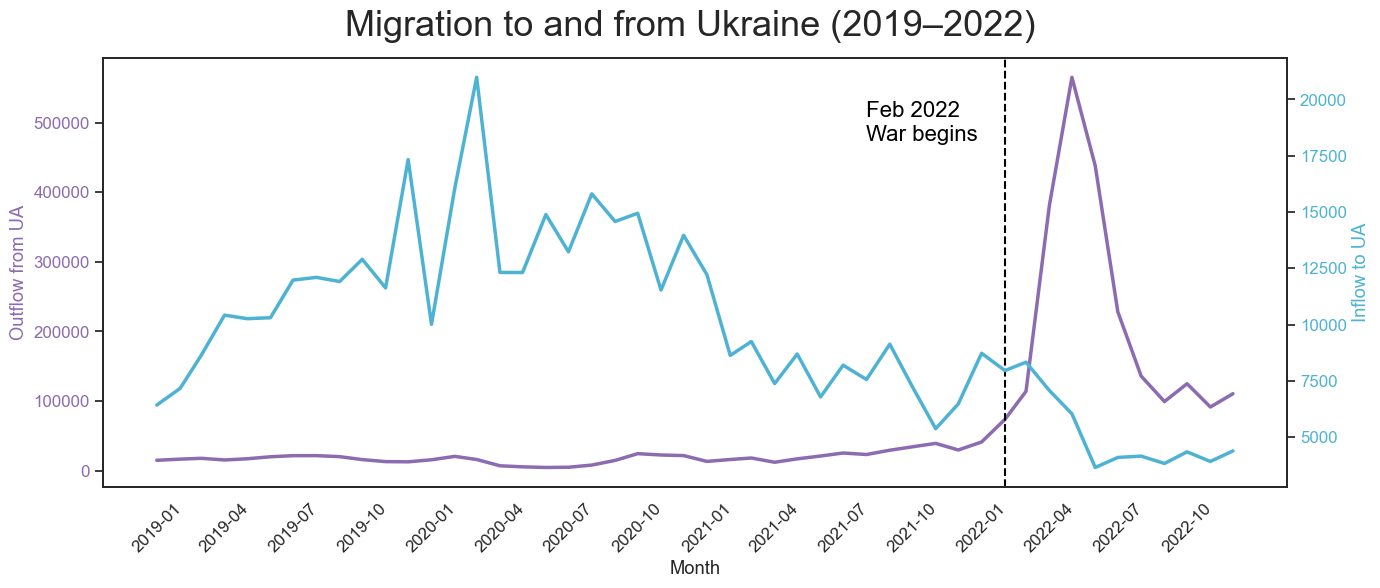

In [20]:
# Ensure datetime index
outflow.index = pd.to_datetime(outflow.index)
inflow.index = pd.to_datetime(inflow.index)

# Apply seaborn style, but remove grid manually
sns.set(style='white', font_scale=1.1)  # 'white' instead of 'whitegrid'

# Create figure and axes
fig, ax1 = plt.subplots(figsize=(14, 6))

# Plot Outflow (left y-axis)
# color_out = sns.color_palette("tab10")[0]  # blue
color_out = "#8c6bb1" 
ax1.set_xlabel("Month")
ax1.set_ylabel("Outflow from UA", color=color_out)
ax1.plot(outflow.index, outflow.values, label="Outflow from UA", color=color_out, linewidth=2.5)
ax1.tick_params(axis='y', labelcolor=color_out)

# Remove grid from ax1
ax1.grid(False)

# War onset line
ax1.axvline(pd.to_datetime("2022-02-01"), color='black', linestyle='--', linewidth=1.5)
ax1.text(pd.to_datetime("2021-08-01"), ax1.get_ylim()[1]*0.8, 'Feb 2022\nWar begins', color='black', fontsize=16)

# Plot Inflow (right y-axis)
ax2 = ax1.twinx()
# color_in = sns.color_palette("tab10")[1]  # orange
color_in = "#4eb3d3" 
ax2.set_ylabel("Inflow to UA", color=color_in)
ax2.plot(inflow.index, inflow.values, label="Inflow to UA", color=color_in, linewidth=2.5)
ax2.tick_params(axis='y', labelcolor=color_in)

# Remove grid from ax2 (just in case)
ax2.grid(False)

# Title and ticks
fig.suptitle("Migration to and from Ukraine (2019–2022)", fontsize=26)
ax1.set_xticks(pd.date_range(start=outflow.index.min(), end=outflow.index.max(), freq='3MS'))
ax1.set_xticklabels([d.strftime('%Y-%m') for d in pd.date_range(start=outflow.index.min(), end=outflow.index.max(), freq='3MS')], rotation=45)

fig.tight_layout()
fig.subplots_adjust(top=0.9)
plt.savefig('UA_migration_outflow_inflow_2019_2022.png', dpi=300, bbox_inches='tight')
plt.show()

# Total Migration

In [21]:
# --- Create inflow and outflow DataFrames ---
inflow_df = df.rename(columns={'country_to': 'geo', 'country_from': 'country'})
inflow_df['flow_type'] = 'inflow'

outflow_df = df.rename(columns={'country_from': 'geo', 'country_to': 'country'})
outflow_df['flow_type'] = 'outflow'

# --- Combine both ---
individual_df = pd.concat([inflow_df, outflow_df], ignore_index=True)

# --- Rename and reorder columns ---
individual_df = individual_df.rename(columns={
    'num_migrants': 'obsValue',
    'year': 'obsTime'
})
individual_df['time_granularity'] = 'Monthly'
individual_df = individual_df[['geo', 'obsTime', 'month', 'time_granularity', 'obsValue', 'flow_type', 'country']]

# --- Merge with combined migration dataset ---
final = pd.concat([individual_df, migration_combined], ignore_index=True)

# --- Merge with geometry ---
merged_migration = final.merge(gdf_country, left_on='geo', right_on='CNTR_CODE', how='inner').drop(columns='CNTR_CODE')

# --- Geo source column (example logic) ---
merged_migration['geo_source'] = np.where(
    merged_migration['geo'] == 'UK',
    'NUTS2021',
    'NUTS2024'
)

# --- Filter relevant data ---
merged_migration = merged_migration[
    (merged_migration['month'] != 'all') &
    (merged_migration['time_granularity'] == 'Total Migration')
].copy()

# --- Convert to datetime ---
merged_migration['date'] = pd.to_datetime(
    merged_migration['obsTime'].astype(str) + '-' + merged_migration['month'].astype(str).str.zfill(2)
)

# --- Convert to GeoDataFrame ---
gdf = gpd.GeoDataFrame(merged_migration, geometry='geometry')
gdf = gdf.set_crs("EPSG:3035")

# --- Filter date range ---
gdf = gdf[(gdf['date'] >= '2019-01-01') & (gdf['date'] <= '2022-12-31')]

KeyError: 'CNTR_CODE'

In [ ]:
# --- Set flow type: inflow or outflow ---
flow_ty = 'outflow'  # or 'outflow'
gdf_plot = gdf[gdf['flow_type'] == flow_ty]

# --- Color scale and map ---
vmin = gdf_plot['obsValue'].quantile(0.05)
vmax = gdf_plot['obsValue'].quantile(0.95)

cmap = 'Blues' if flow_ty == 'inflow' else 'Reds'

# --- Define plotting function ---
def plot_monthly_flows(date, gdf_data, flow_type, save_path):
    fig, ax = plt.subplots(figsize=(10, 6))

    # Filter by date
    monthly_data = gdf_data[gdf_data['date'] == date]

    # Pivot to get inflow/outflow side-by-side (if needed)
    pivot = monthly_data.pivot_table(index='geo', columns='flow_type', values='obsValue', aggfunc='sum', fill_value=0)
    merged = monthly_data.drop_duplicates('geo').set_index('geo').join(pivot)

    # Plot selected flow
    if flow_type in merged.columns:
        merged.plot(
            ax=ax,
            column=flow_type,
            cmap=cmap,
            legend=True,
            legend_kwds={'label': flow_type.capitalize()},
            vmin=vmin,
            vmax=vmax,
        )
    ax.set_xlim([2500000, 7500000])
    ax.set_ylim([1300000, 5500000])
    ax.set_title(f"Migration Flows: {flow_type.capitalize()} – {date.strftime('%Y-%m')}")
    ax.axis('off')
    plt.savefig(save_path, bbox_inches='tight')
    plt.close()

# --- Generate all frames ---
dates = pd.date_range(start="2019-01-01", end="2022-12-01", freq='MS')

for date in tqdm(dates, desc=f"Generating {flow_ty} frames"):
    frame_path = output_dir / f"{flow_ty}_{date.strftime('%Y-%m')}.png"
    plot_monthly_flows(date, gdf_plot, flow_ty, frame_path)

# --- Generate GIF ---
images = []
for date in dates:
    path = output_dir / f"{flow_ty}_{date.strftime('%Y-%m')}.png"
    if path.exists():  # Safe check
        images.append(imageio.imread(path))

gif_path = f"{flow_ty}_migration_flows.gif"
imageio.mimsave(gif_path, images, fps=5)
print(f"✅ GIF saved to {gif_path}")

In [ ]:
# individual_df[(individual_df['geo'] == 'AE') & (individual_df['obsTime'] == 2019) & (individual_df['flow_type'] == 'inflow') & (individual_df['month'] == 1)]['obsValue'].sum()
individual_df[(individual_df['geo'] == 'AE') & (individual_df['obsTime'] == 2019) & (individual_df['flow_type'] == 'inflow')]['obsValue'].sum()

In [ ]:
migration_combined[(migration_combined['geo'] == 'AE') & (migration_combined['obsTime'] == 2019) & (migration_combined['flow_type'] == 'inflow') & (migration_combined['month'] == 'all')]

In [ ]:
migration_combined[(migration_combined['geo'] == 'AE') & (migration_combined['obsTime'] == 2019) & (migration_combined['flow_type'] == 'inflow') & (migration_combined['month'] != 'all')]['obsValue'].sum()

In [ ]:
final = pd.concat([individual_df, migration_combined], ignore_index=True)
final